In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import SVG

import tensorflow as tf
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.layers import Dense, Dropout, Normalization
from tensorflow.keras.utils import model_to_dot

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


2023-10-21 14:07:05.596138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import data
dataset_path = "insurance.csv"
dataset = pd.read_csv(dataset_path)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
dataset.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [5]:
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [6]:
# Encode the data

# dataset['male'] = (dataset['sex'] == 'male') * 1

# for r in dataset['region'].unique():
#     dataset[r] = (dataset['region'] == r) * 1

# dataset['smoker_yes'] = (dataset['smoker'] == 'yes') * 1

# # Drop unnecessary data
# dataset1 = dataset.drop(columns=['sex', 'smoker', 'region'])

dataset1 = pd.get_dummies(dataset, drop_first=True, dtype=int)

In [7]:
dataset1.head()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,0,1,0,0,1
1,18,33.8,1,1725.55,1,0,0,1,0
2,28,33.0,3,4449.46,1,0,0,1,0
3,33,22.7,0,21984.47,1,0,1,0,0
4,32,28.9,0,3866.86,1,0,1,0,0


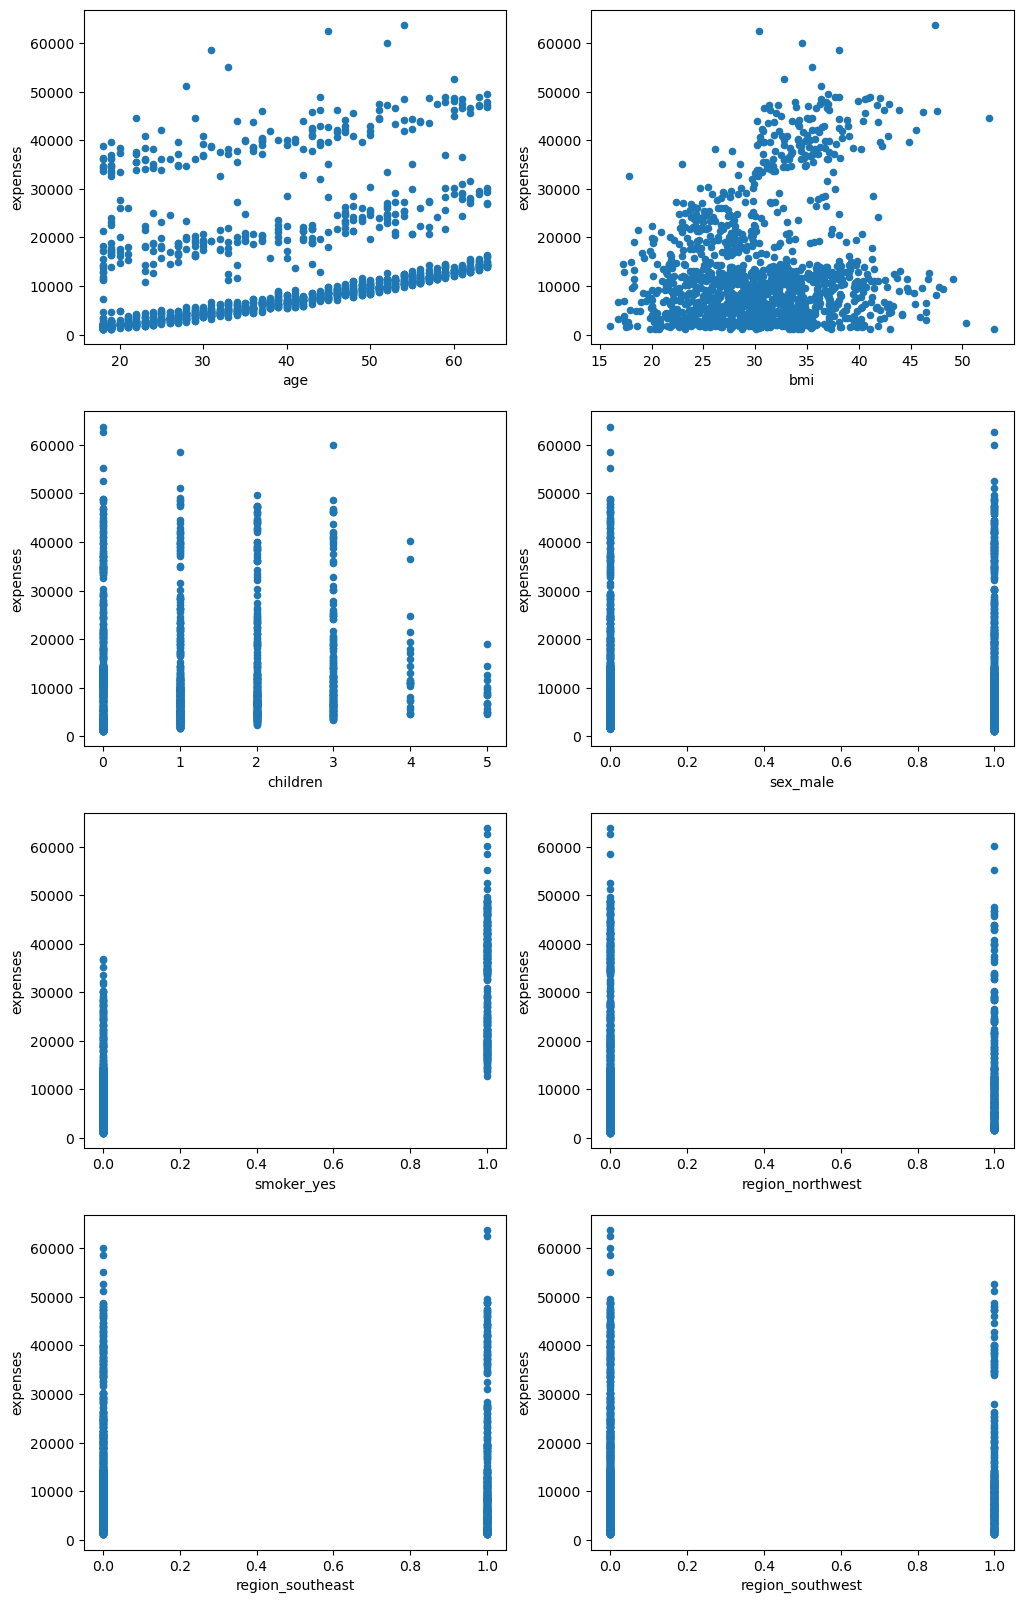

In [8]:
# Check the correlation between expenses and others
cols = dataset1.columns.drop('expenses')
fig, axes = plt.subplots(int(np.ceil((len(dataset1.columns) - 1)/ 2)) , 2, figsize=(12, 20))
for col, ax in zip(cols, [x for v in axes for x in v]):
    dataset1.plot.scatter(x=col, y='expenses', ax=ax)

In [9]:
# Split the data into train and test
train_dataset = dataset1.sample(frac=0.8, random_state=0)
test_dataset = dataset1.drop(train_dataset.index)

In [10]:
# Copy the train and test dataset
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [11]:
# Create train labels and test labels
# train_labels = train_dataset.pop('expenses')
# test_labels = test_dataset.pop('expenses')

train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

In [12]:
# Check the train data
train_stats = train_features.describe().transpose()[['mean', 'std']]
train_stats

,mean,std
age,39.036449,14.142122
bmi,30.737290,6.065193
children,1.093458,1.211364
sex_male,0.498131,0.500230
smoker_yes,0.199065,0.399484
region_northwest,0.235514,0.424518
region_southeast,0.281308,0.449848
region_southwest,0.234579,0.423934


In [13]:
# Standardize the data
def norm(x, stats):
    return (x-stats['mean'])/stats['std']
norm_train_features = norm(train_features, train_stats)
norm_test_features = norm(test_features, train_stats)

In [14]:
# Build and Compile model
def build_compile_model(features, norm=None):
    
    # build model
    model = Sequential()
    if norm:
        model.add(norm)
    model.add(Dense(64, activation='relu', input_shape=[len(features.keys())]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    
    # complile model
    model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae', 'mse'])
    
    return model

In [15]:
model = build_compile_model(norm_train_features)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


2023-10-21 14:07:09.354631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


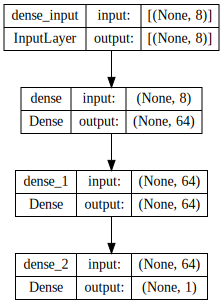

In [16]:
# plot model
SVG(model_to_dot(model, show_shapes=True, expand_nested=False, dpi=72).create(prog='dot', format='svg'))

In [17]:
# Show the progress of model fit
class PrintDot(callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
#             print('')
#         print(epoch, '.', end='')
            print(epoch, end=' ')

In [18]:
# Fit motel
def fit_model(input_model, features, labels, EPOCHS):
    model_history = input_model.fit(
    features,
    labels,
    epochs=EPOCHS,
    validation_split = 0.2,
    verbose=0,
    callbacks=[PrintDot()])
    return model_history

In [19]:
EPOCHS = 1000
history = fit_model(model, norm_train_features, train_labels, EPOCHS)

0 100 200 300 400 500 600 700 800 900 

In [20]:
# Plot mae
def plot_error(input_history, title):
    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot({'Early Stopping': input_history}, metric= 'mae')
    plt.title(title)
    plt.ylabel('Mean Abs Error (expenses)')

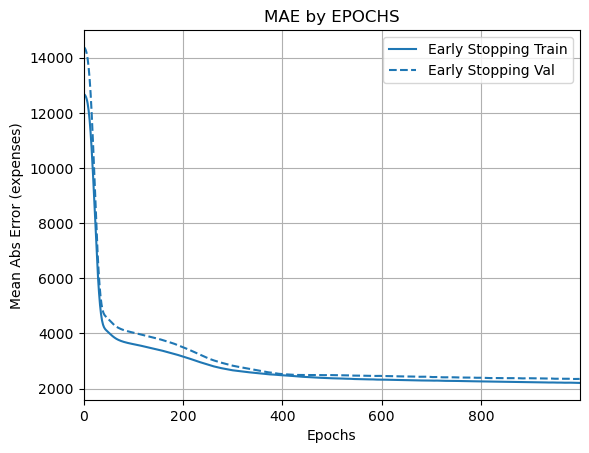

In [21]:
plot_error(history, 'MAE by EPOCHS')

In [22]:
def plot_linear(input_model, features, labels):
    loss, mae, mse = input_model.evaluate(features, labels, verbose=2)

    print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

    if mae < 3500:
      print("You passed the challenge. Great job!")
    else:
      print("The Mean Abs Error must be less than 3500. Keep trying.")

    # Plot predictions.
    predictions = input_model.predict(features).flatten()

    a = plt.axes(aspect='equal')
    plt.scatter(labels, predictions)
    plt.xlabel('True values (expenses)')
    plt.ylabel('Predictions (expenses)')
    lims = [0, 50000]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims,lims, color='red')
    return predictions

9/9 - 0s - loss: 30989422.0000 - mae: 2911.5195 - mse: 30989422.0000 - 22ms/epoch - 2ms/step
Testing set Mean Abs Error: 2911.52 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 982us/step


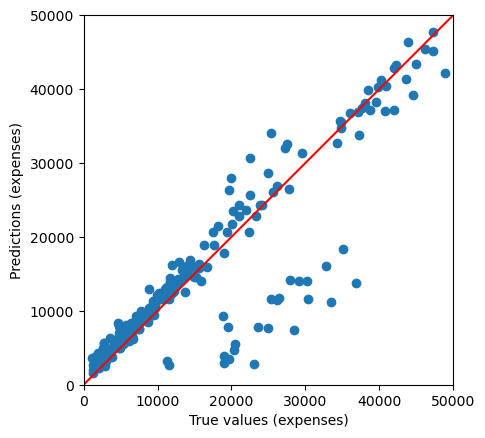

In [23]:
test_predictions = plot_linear(model, norm_test_features, test_labels)

In [24]:
def plot_hist(predictions, labels):
    error = predictions - labels
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Expenses]')
    _ = plt.ylabel('Count')

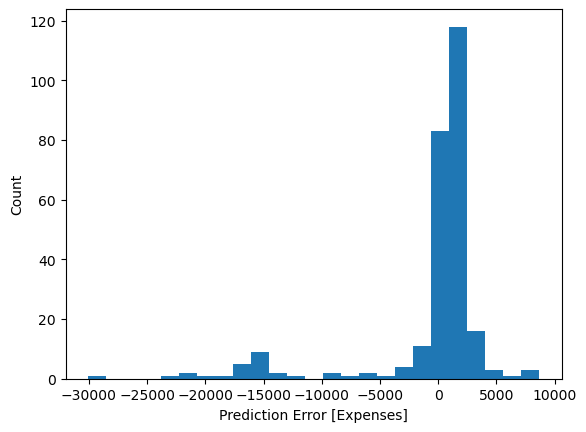

In [25]:
plot_hist(test_predictions, test_labels)

# Use keras normalization

In [26]:
# Build Normalizer
normalizer = Normalization(axis=1)

In [27]:
# Adapt normalizer with train_features
normalizer.adapt(np.array(train_features))

In [28]:
print(normalizer.mean.numpy())

[[39.036446   30.737288    1.093458    0.49813083  0.19906542  0.23551399
   0.28130844  0.23457943]]


In [29]:
train_stats

,mean,std
age,39.036449,14.142122
bmi,30.737290,6.065193
children,1.093458,1.211364
sex_male,0.498131,0.500230
smoker_yes,0.199065,0.399484
region_northwest,0.235514,0.424518
region_southeast,0.281308,0.449848
region_southwest,0.234579,0.423934


In [30]:
model_normalizer = build_compile_model(train_features, normalizer)
model_normalizer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                576       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


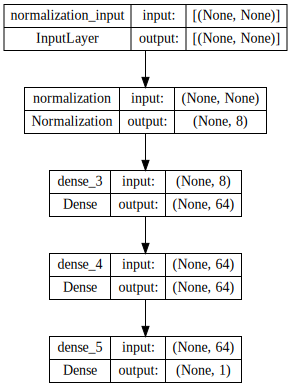

In [31]:
# plot model
SVG(model_to_dot(model_normalizer, show_shapes=True, expand_nested=False, dpi=72).create(prog='dot', format='svg'))

In [32]:
EPOCHS = 1000
history_normalizer = fit_model(model_normalizer, train_features, train_labels, EPOCHS)

0 100 200 300 400 500 600 700 800 900 

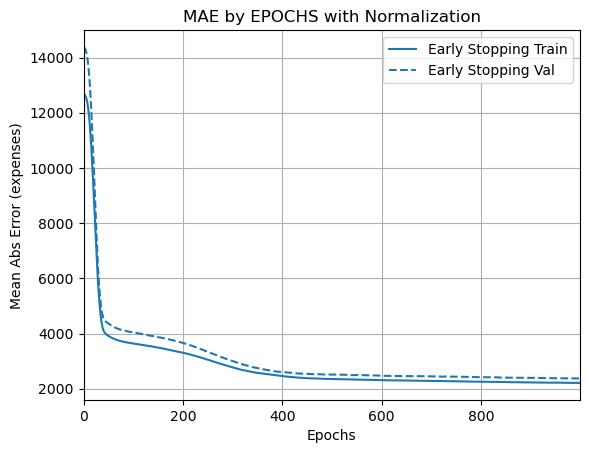

In [33]:
plot_error(history_normalizer, 'MAE by EPOCHS with Normalization')

9/9 - 0s - loss: 30850642.0000 - mae: 2890.0464 - mse: 30850642.0000 - 25ms/epoch - 3ms/step
Testing set Mean Abs Error: 2890.05 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 1ms/step


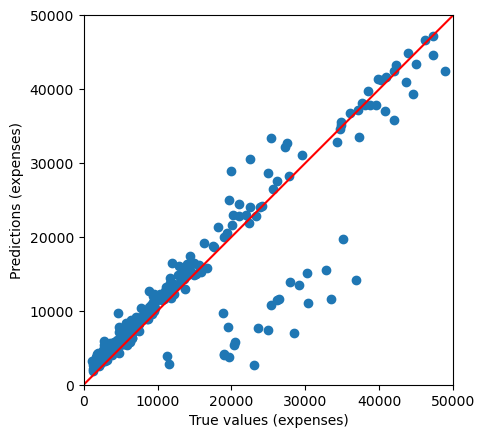

In [34]:
test_predictions1 = plot_linear(model_normalizer, test_features, test_labels)

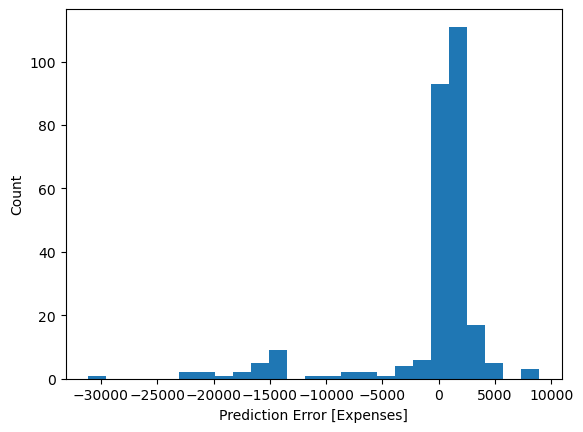

In [35]:
plot_hist(test_predictions1, test_labels)